In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Preprocess

In [2]:
df = pd.read_csv("/Users/tongtianyi/Desktop/Spring 2024/ml and ai for health/finalproject/final/final_filtered_df.csv")
df.shape

(2698, 26)

In [3]:
# Checking for uniqueness
is_unique = df['Case-Safe ID'].is_unique
is_unique

True

### merge with student applicaiton data 

In [4]:
gpa = pd.read_excel("/Users/tongtianyi/Desktop/Spring 2024/ml and ai for health/finalproject/student_application.xlsx")
gpa.shape

(2840, 14)

In [5]:
# Selecting only 'Case-Safe ID' and 'GPA' columns from the gpa DataFrame
gpa_selected = gpa[['Case-Safe ID', 'GPA Unweighted','Student Application: Gender','Student Application: I Live With']]

# Merging the selected columns into enroll_df
df = pd.merge(df, gpa_selected, on='Case-Safe ID', how='inner')

In [6]:
df['persistence'] = df['persistent']
del df['persistent']

In [7]:
df['persistence'].value_counts()

1    2008
0     690
Name: persistence, dtype: int64

In [8]:
df['retention'] = df['persistent_same_school']
del df['persistent_same_school']

In [9]:
df['retention'].value_counts()

1    1667
0    1031
Name: retention, dtype: int64

### Outlier Identification & Missing Value Imputation

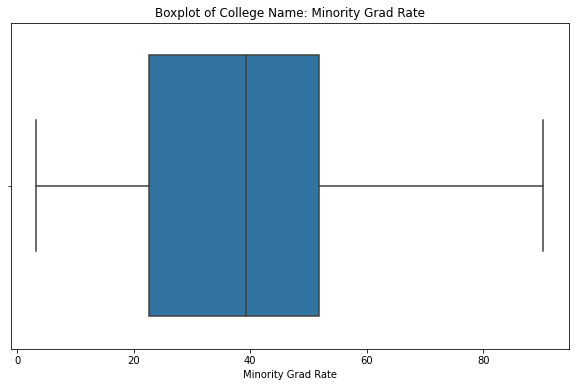

In [10]:
# Setting up the plotting area
plt.figure(figsize=(10, 6))
sns.boxplot(x='College Name: Minority Grad Rate', data=df)

# Adding title and labels
plt.title('Boxplot of College Name: Minority Grad Rate')
plt.xlabel('Minority Grad Rate')

# Display the plot
plt.show()

In [11]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['College Name: Minority Grad Rate'].quantile(0.25)
Q3 = df['College Name: Minority Grad Rate'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Determine the outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['College Name: Minority Grad Rate'] < lower_bound) | 
                    (df['College Name: Minority Grad Rate'] > upper_bound)]

# Display outliers
print("Outliers:")
print(outliers)


Outliers:
Empty DataFrame
Columns: [Case-Safe ID, GW Class Year, GW Location, College Name: Account Name, Age, FRL, First Generation?, Race/Ethnicity, Current Last Enrollment Begin, College Type (2 vs 4 year), 2nd Year College Persistence, College Name: Public vs. Private, College Name: Minority Grad Rate, College Name: School Size, college_name, college_state, GW_location, college_location, timeline, uni_amount, records_amount, persistence, transfer, in_state, GPA Unweighted, Student Application: Gender, Student Application: I Live With, retention]
Index: []

[0 rows x 28 columns]


In [12]:
from sklearn.impute import KNNImputer
import numpy as np

imputer = KNNImputer(n_neighbors=10) 

df['minority'] = imputer.fit_transform(df[['College Name: Minority Grad Rate']])

# Check if NaNs are still present
print("Remaining NaNs in dataset:", np.isnan(df['minority']).sum())


Remaining NaNs in dataset: 0


In [13]:
df['FRL'] = df['FRL'].replace({'Yes': 1, 'No': 0, 'Unsure': 0, np.nan: 0})
df['first_gen'] = df['First Generation?'].replace({'Yes': 1, 'No': 0, np.nan: 0})
df['4_year'] = df['College Type (2 vs 4 year)'].replace({'4 year': 1, '2 year': 0, np.nan: 1})

In [14]:
print("Remaining NaNs in dataset:", np.isnan(df['FRL']).sum())
print("Remaining NaNs in dataset:", np.isnan(df['first_gen']).sum())
print("Remaining NaNs in dataset:", np.isnan(df['4_year']).sum())

Remaining NaNs in dataset: 0
Remaining NaNs in dataset: 0
Remaining NaNs in dataset: 0


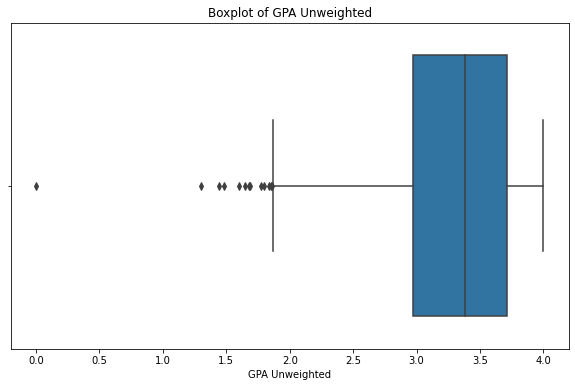

In [15]:
# Setting up the plotting area
plt.figure(figsize=(10, 6))
sns.boxplot(x='GPA Unweighted', data=df)

# Adding title and labels
plt.title('Boxplot of GPA Unweighted')
plt.xlabel('GPA Unweighted')

# Display the plot
plt.show()

In [16]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['GPA Unweighted'].quantile(0.25)
Q3 = df['GPA Unweighted'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Determine the outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['GPA Unweighted'] < lower_bound) | 
                    (df['GPA Unweighted'] > upper_bound)]

# Display outliers
print("Outliers:")
print(outliers)


Outliers:
            Case-Safe ID  GW Class Year  GW Location  \
387   0030h00002JXUIqAAP           2019  Twin Cities   
619   0030h00002R1EZSAA3           2020  Twin Cities   
645   0030h00002R3iUIAAZ           2020      Houston   
833   0030h00002RaayzAAB           2020      Houston   
946   0030h00002RsIWHAA3           2020  Twin Cities   
1381  0030h00002aE1QMAA0           2021      Chicago   
1525  0031A000028V5jhQAC           2018      Houston   
1652  0031A000028gqbdQAA           2018      Houston   
1678  0031A000028uG5lQAE           2018  Twin Cities   
1700  0031A000028vIBGQA2           2018  Twin Cities   
1762  0031A000028xLG7QAM           2018      Houston   
2406  0034u00002cffV2AAI           2023     Bay Area   
2458  0034u00002gp1ktAAA           2023  Twin Cities   

               College Name: Account Name  Age  FRL First Generation?  \
387         Inver Hills Community College   23  1.0               Yes   
619         Inver Hills Community College   21  1.0        

In [17]:
# Replace outliers with lower_bound
df.loc[df['GPA Unweighted'] < lower_bound, 'GPA Unweighted'] = lower_bound
df.loc[df['GPA Unweighted'] > upper_bound, 'GPA Unweighted'] = upper_bound


In [18]:
print("Remaining NaNs in dataset:", np.isnan(df['GPA Unweighted']).sum())


Remaining NaNs in dataset: 593


In [19]:
imputer = KNNImputer(n_neighbors=10) 

df['gpa'] = imputer.fit_transform(df[['GPA Unweighted']])

# Check if NaNs are still present
print("Remaining NaNs in dataset:", np.isnan(df['gpa']).sum())


Remaining NaNs in dataset: 0


### Recategorization

In [20]:
df['Student Application: I Live With'].unique()

array(['Two parents', 'One parent', 'A family member', 'Other',
       'A family member (like a grandparent, aunt/uncle, or sibling)',
       nan], dtype=object)

In [21]:
categorization_map = {
    'Two parents': 'Two parents',
    'One parent': 'One parent',
    'A family member': 'Other',
    'Other': 'Other',
    'A family member (like a grandparent, aunt/uncle, or sibling': 'Other',
    np.nan: 'Other'
}

# Applying the categorization
df['household'] = df['Student Application: I Live With'].map(categorization_map)


In [22]:
df['household'] = df['household'].fillna('Other')

In [23]:
df['household'].unique()

array(['Two parents', 'One parent', 'Other'], dtype=object)

In [24]:
df['Student Application: Gender'].unique()

array(['Female', 'Male', nan, 'Not disclosed', 'Non-binary'], dtype=object)

In [25]:
categorization_map = {
    'Female': 'Female',
    'Male': 'Male',
    'Not disclosed': 'Other',
    'Non-binary': 'Other',
    np.nan: 'Other'
}

# Applying the categorization
df['gender'] = df['Student Application: Gender'].map(categorization_map)


In [26]:
df['gender'].unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [27]:
df['Race/Ethnicity'].unique()

array(['African Immigrant', 'African American',
       'Black or African American', 'Hmong', 'Hispanic or Latino',
       'Other Asian', 'Asian', 'Two or More Races', 'Caucasian', 'Other',
       nan, 'Not Disclosed', 'White', 'Native American or Alaska Native',
       'Black', 'Native Hawaiian or Pacific Islander',
       'Hawaiian/Pacific Islander', 'American Indian/Alaskan Native'],
      dtype=object)

In [28]:
categorization_map = {
    'African Immigrant': 'Black or African American',
    'African American': 'Black or African American',
    'Black or African American': 'Black or African American',
    'Black': 'Black or African American',
    'Hmong': 'Asian',
    'Other Asian': 'Asian',
    'Asian': 'Asian',
    'Hispanic or Latino': 'Hispanic or Latino',
    'Two or More Races': 'Other',
    'Caucasian': 'White',
    'White': 'White',
    'Native American or Alaska Native': 'Indigenous/Islander',
    'American Indian/Alaskan Native': 'Indigenous/Islander',
    'Native Hawaiian or Pacific Islander': 'Indigenous/Islander',
    'Hawaiian/Pacific Islander': 'Indigenous/Islander',
    'Other': 'Other',
    'Not Disclosed': 'Other',
    None: 'Other'
}

# Applying the categorization
df['race'] = df['Race/Ethnicity'].map(categorization_map)


In [29]:
df['College Name: Public vs. Private'].unique()

array(['Public', 'Private not-for-profit', 'Private for-profit',
       'Private', nan], dtype=object)

In [30]:
categorization_map = {
    'Private not-for-profit': 0,
    'Private for-profit': 0,
    'Public': 1,
    'Private': 0
}

# Applying the categorization
df['public'] = df['College Name: Public vs. Private'].map(categorization_map)


In [31]:
majority_gender = df['gender'].value_counts().idxmax()
df['Gender'] = df['gender'].replace('Other', majority_gender)
df['Gender']

0       Female
1       Female
2       Female
3         Male
4         Male
         ...  
2693    Female
2694      Male
2695    Female
2696    Female
2697    Female
Name: Gender, Length: 2698, dtype: object

In [32]:
df['race'].unique()

array(['Black or African American', 'Asian', 'Hispanic or Latino',
       'Other', 'White', nan, 'Indigenous/Islander'], dtype=object)

In [33]:
df['Race'] = df['race'].fillna('Black or African American')

In [34]:
df['Race'] = df['Race'].replace('Indigenous/Islander', 'Other')

In [35]:
df['Race'].value_counts()

Black or African American    977
Hispanic or Latino           863
Asian                        624
Other                        142
White                         92
Name: Race, dtype: int64

In [36]:
df.columns

Index(['Case-Safe ID', 'GW Class Year', 'GW Location',
       'College Name: Account Name', 'Age', 'FRL', 'First Generation?',
       'Race/Ethnicity', 'Current Last Enrollment Begin',
       'College Type (2 vs 4 year)', '2nd Year College Persistence',
       'College Name: Public vs. Private', 'College Name: Minority Grad Rate',
       'College Name: School Size', 'college_name', 'college_state',
       'GW_location', 'college_location', 'timeline', 'uni_amount',
       'records_amount', 'persistence', 'transfer', 'in_state',
       'GPA Unweighted', 'Student Application: Gender',
       'Student Application: I Live With', 'retention', 'minority',
       'first_gen', '4_year', 'gpa', 'household', 'gender', 'race', 'public',
       'Gender', 'Race'],
      dtype='object')

### select features for modeling

In [37]:
df_new = df[[
       'FRL', 'Age',
       'college_name', 'persistence', 'in_state',
       'gpa', 'Gender',
       'household', 'minority', 'first_gen', '4_year', 'Race', 'public']]

In [38]:
nan_in_df = df_new.isnull().sum().any()
 
nan_in_df

True

In [39]:
# Filter and display the rows with any missing values
rows_with_missing_values = df_new[df_new.isna().any(axis=1)]

rows_with_missing_values

,FRL,Age,college_name,persistence,in_state,gpa,Gender,household,minority,first_gen,4_year,Race,public
1113,0.0,21,Texas State Technical College-Fort Bend,0,1,3.070000,Female,One parent,38.544339,1.0,1.0,Hispanic or Latino,NaN
1666,1.0,24,Year Up Chicago,0,1,2.523000,Male,Other,38.544339,1.0,1.0,Hispanic or Latino,NaN
2177,1.0,20,American University,1,0,3.303456,Male,Two parents,38.544339,1.0,1.0,Asian,NaN
2330,0.0,18,City College of New York,0,1,3.303456,Male,Two parents,38.544339,1.0,1.0,Hispanic or Latino,NaN
2450,0.0,18,Minneapolis Community & Technical College,0,1,3.270000,Male,One parent,38.544339,1.0,1.0,Black or African American,NaN
2474,0.0,20,Binghamton University,0,1,3.303456,Female,One parent,38.544339,1.0,1.0,Hispanic or Latino,NaN
2582,0.0,19,Minneapolis Community & Technical College,0,1,2.100000,Male,Two parents,38.544339,1.0,1.0,Black or African American,NaN
2589,1.0,19,City College of New York,0,1,3.303456,Male,Other,38.544339,1.0,1.0,Hispanic or Latino,NaN


In [40]:
# Mapping dictionary
college_public_mapping = {
    'Texas State Technical College-Fort Bend': 1,
    'Year Up Chicago': 1,  
    'American University': 0,
    'City College of New York': 1,
    'Minneapolis Community & Technical College': 1,
    'Binghamton University': 1
}

# Impute the 'public' column using the mapping
# df_new['public'] = df_new['college_name'].map(college_public_mapping)
df_new['public'] = df_new.apply(
    lambda row: college_public_mapping[row['college_name']] if pd.isna(row['public']) and row['college_name'] in college_public_mapping else row['public'],
    axis=1
)

/var/folders/q4/5hhtt44n6l36cfs0cvvv4g2m0000gn/T/ipykernel_76056/2077660435.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['public'] = df_new.apply(


In [41]:
nan_in_df = df_new.isnull().sum().any()
 
nan_in_df

False

In [42]:
# Selecting numerical variables for multicollinearity analysis after transforming categorical variables
numerical_vars = df_new.select_dtypes(include=['int64', 'float64']).columns

# Adding a constant for the intercept
X = add_constant(df_new[numerical_vars])

# Calculating VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(0, X.shape[1])]

vif_data[1:]

,Variable,VIF
1,FRL,1.082813
2,Age,1.348427
3,persistence,1.316282
4,in_state,1.101829
5,gpa,1.260789
6,minority,1.484190
7,first_gen,1.113393
8,4_year,1.432505
9,public,1.187447


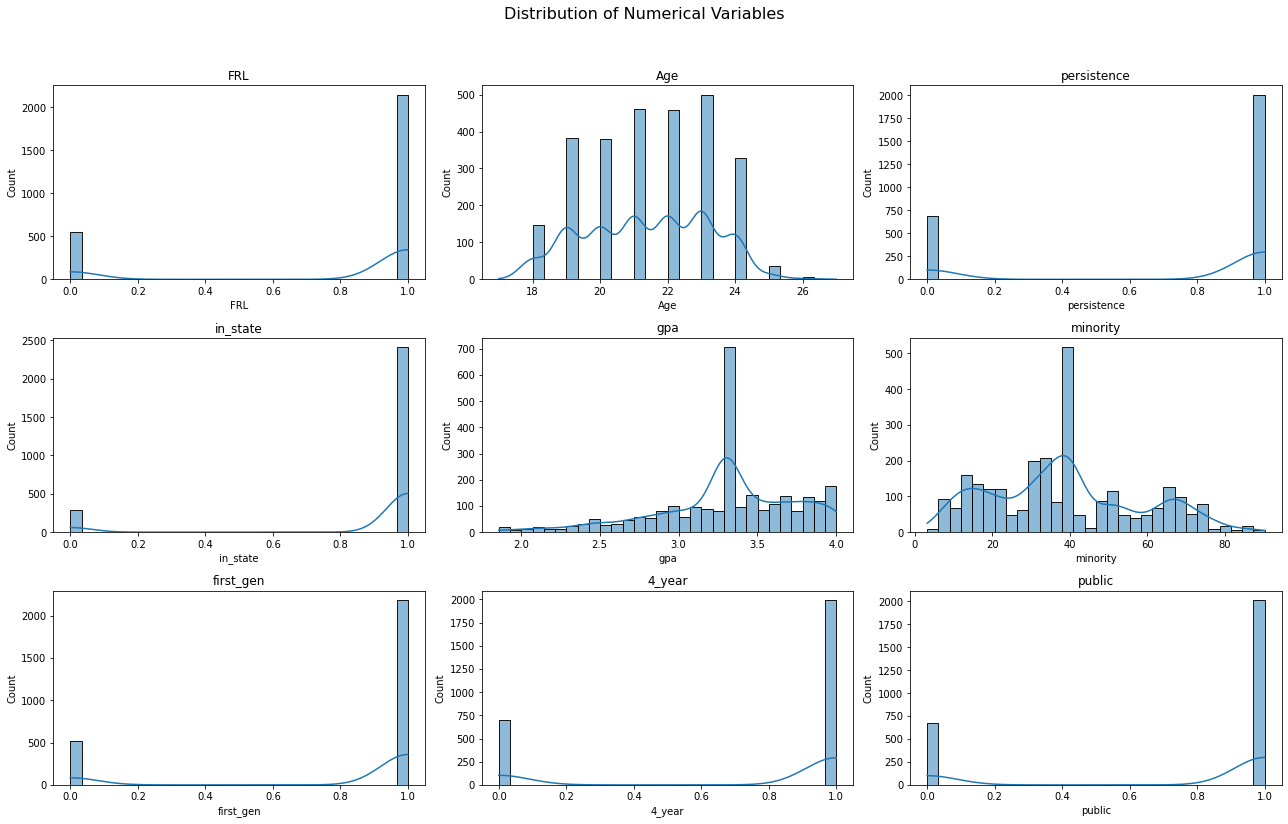

In [43]:
# Plotting distributions for all numerical variables to check for outliers and noise
numerical_variables = df_new.select_dtypes(include=['int64', 'float64']).columns

# Setting up the plotting area
n_rows = len(numerical_variables) // 3 + (len(numerical_variables) % 3 > 0)
fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 4))
fig.suptitle('Distribution of Numerical Variables', fontsize=16)

for i, var in enumerate(numerical_variables):
    row = i // 3
    col = i % 3
    sns.histplot(df[var], kde=True, ax=axes[row, col], bins=30)
    axes[row, col].set_title(var)

# Adjust layout to prevent overlap and remove empty subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
if len(numerical_variables) % 3:
    for j in range(3 - len(numerical_variables) % 3):
        fig.delaxes(axes.flatten()[-(j + 1)])

plt.show()

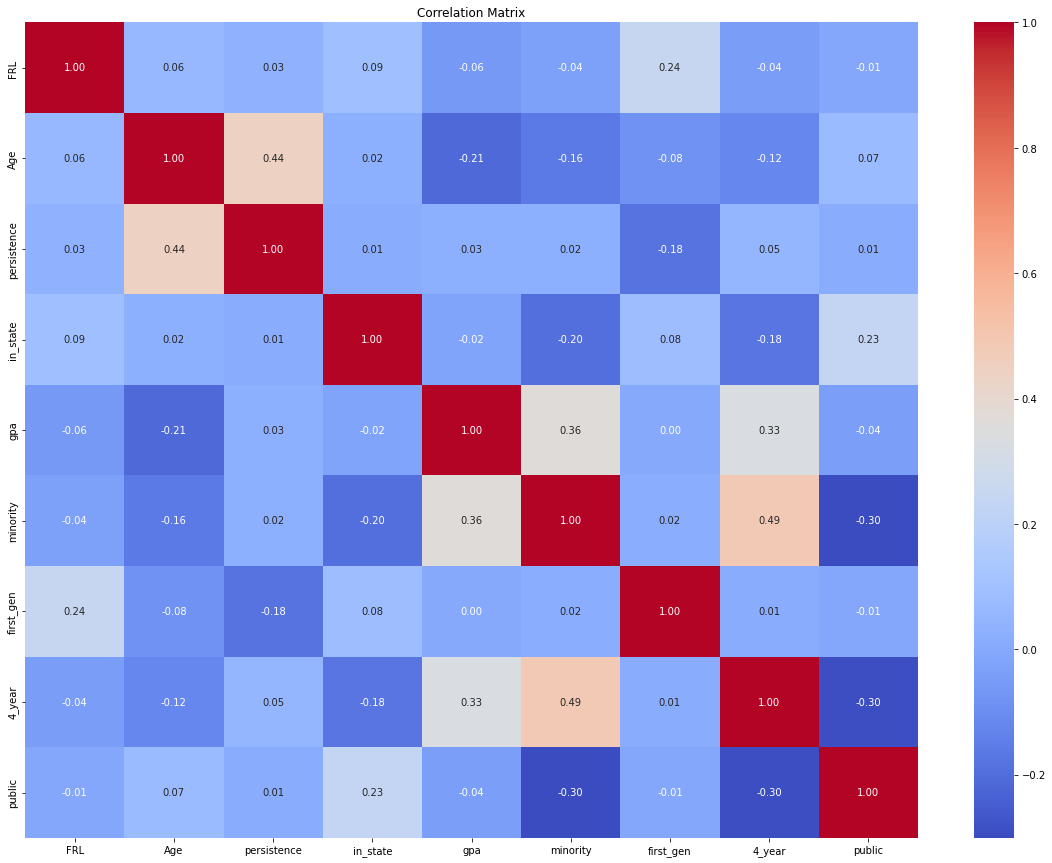

In [44]:
# Calculating the correlation matrix 
correlation_matrix_dropped = df_new.select_dtypes(include=['int64', 'float64']).corr()

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix_dropped, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [45]:
# Converting the identified potential categorical variables from 1.2.3 to categorical
categorical_vars = [
    'Gender',
    'household',
    'Race'
]

for var in categorical_vars:
    df_new[var] = df_new[var].astype('category')

/var/folders/q4/5hhtt44n6l36cfs0cvvv4g2m0000gn/T/ipykernel_76056/4291888347.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[var] = df_new[var].astype('category')
/var/folders/q4/5hhtt44n6l36cfs0cvvv4g2m0000gn/T/ipykernel_76056/4291888347.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[var] = df_new[var].astype('category')
/var/folders/q4/5hhtt44n6l36cfs0cvvv4g2m0000gn/T/ipykernel_76056/4291888347.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [46]:
for var in categorical_vars:
    print(f"Counts for {var}:")
    print(df[var].value_counts())
    print()


Counts for Gender:
Female    1532
Male      1166
Name: Gender, dtype: int64

Counts for household:
Two parents    1707
One parent      819
Other           172
Name: household, dtype: int64

Counts for Race:
Black or African American    977
Hispanic or Latino           863
Asian                        624
Other                        142
White                         92
Name: Race, dtype: int64



In [47]:
# Generate counts and percentages
for var in categorical_vars:
    count = df[var].value_counts()
    percent = df[var].value_counts(normalize=True) * 100
    table = pd.DataFrame({'Counts': count, 'Percentage': percent})
    print(f"Counts and Percentage for {var}:")
    print(table)
    print()


Counts and Percentage for Gender:
        Counts  Percentage
Female    1532   56.782802
Male      1166   43.217198

Counts and Percentage for household:
             Counts  Percentage
Two parents    1707   63.269088
One parent      819   30.355819
Other           172    6.375093

Counts and Percentage for Race:
                           Counts  Percentage
Black or African American     977   36.212009
Hispanic or Latino            863   31.986657
Asian                         624   23.128243
Other                         142    5.263158
White                          92    3.409933



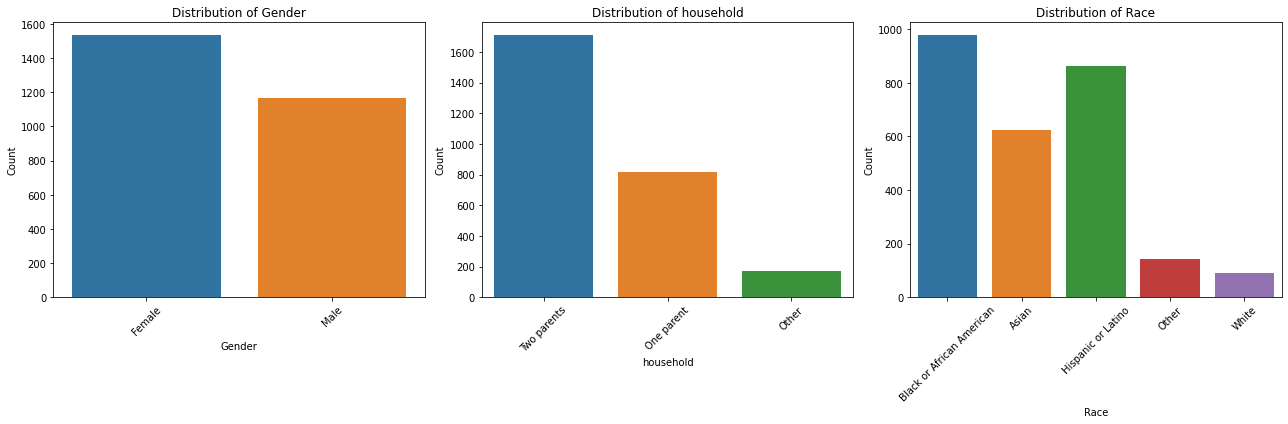

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, var in enumerate(categorical_vars):
    sns.countplot(ax=axes[i], x=df[var])
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    for label in axes[i].get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()


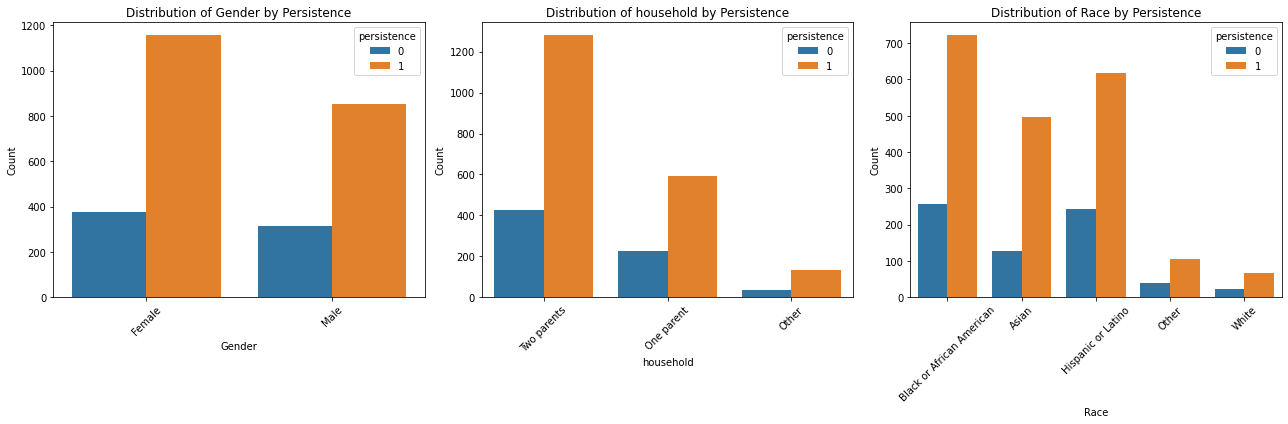

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, var in enumerate(categorical_vars):
    sns.countplot(ax=axes[i], x=df[var], hue=df['persistence'])  # Add 'hue' for the target variable
    axes[i].set_title(f'Distribution of {var} by Persistence')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    for label in axes[i].get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

### 1.3.1 One-Hot Encoding

In [50]:
df_encoded = pd.get_dummies(df_new, columns=['household', 'Race'], drop_first=False)

In [51]:
df_encoded['female'] = df_new['Gender'].apply(lambda x: 1 if x == 'Female' else 0)
df_encoded.drop(columns=['Gender'], inplace=True)
df_encoded['female'] = df_encoded['female'].astype(int)

In [52]:
columns_to_drop = ['household_Other', 'Race_Other']
df_encoded = df_encoded.drop(columns=columns_to_drop)

In [53]:
df_encoded.columns

Index(['FRL', 'Age', 'college_name', 'persistence', 'in_state', 'gpa',
       'minority', 'first_gen', '4_year', 'public', 'household_One parent',
       'household_Two parents', 'Race_Asian', 'Race_Black or African American',
       'Race_Hispanic or Latino', 'Race_White', 'female'],
      dtype='object')

In [54]:
import pandas as pd
import statsmodels.api as sm

# Define X and y
X = df_encoded.drop(columns=df_encoded[['persistence', 'college_name']])
y = df_encoded['persistence']

# Add a constant to the model (the intercept)
X = sm.add_constant(X)

# Initialize and fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print the summary of the regression results
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.430250
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            persistence   No. Observations:                 2698
Model:                          Logit   Df Residuals:                     2682
Method:                           MLE   Df Model:                           15
Date:                Fri, 24 May 2024   Pseudo R-squ.:                  0.2433
Time:                        23:27:13   Log-Likelihood:                -1160.8
converged:                       True   LL-Null:                       -1534.0
Covariance Type:            nonrobust   LLR p-value:                2.469e-149
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -17.2775      1.063    -16.246     

In [55]:
from sklearn.preprocessing import StandardScaler

# Define the continuous variables
continuous_vars = ['gpa', 'minority']

# Scale the continuous variables
scaler = StandardScaler()
scaled_continuous_vars = scaler.fit_transform(df_encoded[continuous_vars])

# Create a DataFrame with the scaled continuous variables
df_scaled = df_encoded.copy()
df_scaled[continuous_vars] = scaled_continuous_vars

# Display the resulting DataFrame
df_scaled


,FRL,Age,college_name,persistence,in_state,gpa,minority,first_gen,4_year,public,household_One parent,household_Two parents,Race_Asian,Race_Black or African American,Race_Hispanic or Latino,Race_White,female
0,1.0,23,North Hennepin Community College,1,1,-0.409635,-1.157908,1.0,0.0,1.0,0,1,0,1,0,0,1
1,1.0,22,Augsburg University,1,1,0.059594,-0.424811,0.0,1.0,0.0,0,1,0,1,0,0,1
2,0.0,22,University of California-Los Angeles,1,0,0.441264,2.112910,1.0,1.0,1.0,0,1,0,1,0,0,1
3,1.0,22,Old Dominion University,1,1,-0.124505,0.195819,1.0,1.0,1.0,0,1,0,1,0,0,0
4,1.0,23,Minneapolis Community and Technical College,1,1,-2.903962,-1.606226,1.0,0.0,1.0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2693,1.0,19,Illinois Institute of Technology,0,1,0.890288,0.778788,1.0,1.0,0.0,1,0,0,1,0,0,1
2694,1.0,19,Columbia College-Chicago,0,1,-2.028366,-0.855589,1.0,1.0,0.0,1,0,0,1,0,0,0
2695,1.0,19,Loyola University Chicago,0,1,-0.905806,1.452556,1.0,1.0,0.0,1,0,0,0,0,0,1
2696,0.0,18,University of Illinois at Urbana-Champaign,0,1,1.227056,1.439142,1.0,1.0,1.0,0,1,0,0,1,0,1


## modeling

### logistic regression

In [56]:
df_scaled['dropout'] = df_scaled['persistence'].replace({1: 0, 0: 1})
df_scaled = df_scaled.drop(columns = 'persistence')

In [57]:
df_scaled['dropout'].value_counts()

0    2008
1     690
Name: dropout, dtype: int64

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score,f1_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, classification_report

# Splitting the dataset into training and testing sets
X = df_scaled.drop(columns=df_scaled[['dropout', 'college_name']])
y = df_scaled['dropout']

# Initialize the naive model
naive_logistic_model = LogisticRegression(max_iter=100000, n_jobs=-1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66, stratify= y)

# Train the model
naive_logistic_model.fit(X_train, y_train)

# Predictions on training set for f-1 calculation
y_train_pred = naive_logistic_model.predict(X_train)

# Get the prediction
y_test_pred = naive_logistic_model.predict(X_test)
y_prob_lr = naive_logistic_model.predict_proba(X_test)[:, 1]

# Calculate f-1 score for both training and testing sets #TP/TP+FN
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# Calculating the evaluation metrics
test_f1_lr = f1_score(y_test, y_test_pred)
test_precision_lr = precision_score(y_test, y_test_pred)
test_recall_lr = recall_score(y_test, y_test_pred)
test_confusion_matrix_lr = confusion_matrix(y_test, y_test_pred)
test_auc_roc_lr = roc_auc_score(y_test, y_prob_lr)

# Printing the results
print(f"Test Set F1 Score: {test_f1_lr:.4f}")
print(f"Test Set Precision Score: {test_precision_lr:.4f}")
print(f"Test Set Recall Score: {test_recall_lr:.4f}")
print(f"Test Set Confusion Matrix:\n{test_confusion_matrix_lr}")
print(f"Test Set AUC-ROC Score: {test_auc_roc_lr:.4f}")
# Printing the classification report
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Test Set F1 Score: 0.6724
Test Set Precision Score: 0.8194
Test Set Recall Score: 0.5700
Test Set Confusion Matrix:
[[577  26]
 [ 89 118]]
Test Set AUC-ROC Score: 0.8422

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91       603
           1       0.82      0.57      0.67       207

    accuracy                           0.86       810
   macro avg       0.84      0.76      0.79       810
weighted avg       0.85      0.86      0.85       810



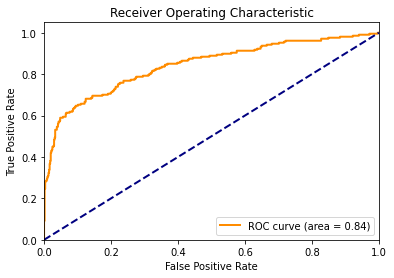

In [91]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for the model
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [92]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'C': np.logspace(-4, 4, 20),
    'class_weight': ['balanced', None],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 1000, 10000, 100000]
}

# Initialize the Logistic Regression model
logistic_model = LogisticRegression(n_jobs=-1)

# Initialize RandomizedSearchCV with AUC-ROC as the scoring metric
random_search = RandomizedSearchCV(logistic_model, param_distributions=param_dist, n_iter=100, 
                                   scoring='roc_auc', cv=5, random_state=66, verbose=1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model
best_logistic_model = random_search.best_estimator_

# Predictions on the test set
y_test_pred = best_logistic_model.predict(X_test)
y_prob_lr = best_logistic_model.predict_proba(X_test)[:, 1]

# Calculate the evaluation metrics
test_f1_lr = f1_score(y_test, y_test_pred)
test_precision_lr = precision_score(y_test, y_test_pred)
test_recall_lr = recall_score(y_test, y_test_pred)
test_confusion_matrix_lr = confusion_matrix(y_test, y_test_pred)
test_auc_roc_lr = roc_auc_score(y_test, y_prob_lr)

# Printing the results
print(f"Best Parameters: {random_search.best_params_}")
print(f"Test Set F1 Score: {test_f1_lr:.4f}")
print(f"Test Set Precision Score: {test_precision_lr:.4f}")
print(f"Test Set Recall Score: {test_recall_lr:.4f}")
print(f"Test Set Confusion Matrix:\n{test_confusion_matrix_lr}")
print(f"Test Set AUC-ROC Score: {test_auc_roc_lr:.4f}")
# Printing the classification report
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarn

/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not h

/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/ana

/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarn

/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarn

/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarn

/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/ana

/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/ana

Best Parameters: {'solver': 'saga', 'max_iter': 1000, 'class_weight': None, 'C': 1.623776739188721}
Test Set F1 Score: 0.6705
Test Set Precision Score: 0.8138
Test Set Recall Score: 0.5700
Test Set Confusion Matrix:
[[576  27]
 [ 89 118]]
Test Set AUC-ROC Score: 0.8424

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91       603
           1       0.81      0.57      0.67       207

    accuracy                           0.86       810
   macro avg       0.84      0.76      0.79       810
weighted avg       0.85      0.86      0.85       810



/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [63]:
# Get the coefficients from the logistic regression model
coefficients = best_logistic_model.coef_[0]

# Create a DataFrame with the feature names and coefficients
feature_importance = pd.DataFrame(data={
    'Feature': X.columns,
    'Coefficient': coefficients
})

# Calculate the absolute value of the coefficients
feature_importance['Absolute Value'] = feature_importance['Coefficient'].abs()

# Sort the features by the absolute value of their coefficient in descending order
feature_importance = feature_importance.sort_values(by='Absolute Value', ascending=False)

# Display the top features
print(feature_importance)


                           Feature  Coefficient  Absolute Value
5                        first_gen     1.352553        1.352553
1                              Age    -0.667323        0.667323
11  Race_Black or African American    -0.395082        0.395082
8             household_One parent    -0.394666        0.394666
6                           4_year    -0.366134        0.366134
9            household_Two parents    -0.347641        0.347641
13                      Race_White     0.308837        0.308837
2                         in_state    -0.284579        0.284579
10                      Race_Asian    -0.271182        0.271182
3                              gpa    -0.248096        0.248096
0                              FRL    -0.181503        0.181503
14                          female    -0.131512        0.131512
4                         minority    -0.117315        0.117315
7                           public    -0.084401        0.084401
12         Race_Hispanic or Latino    -0

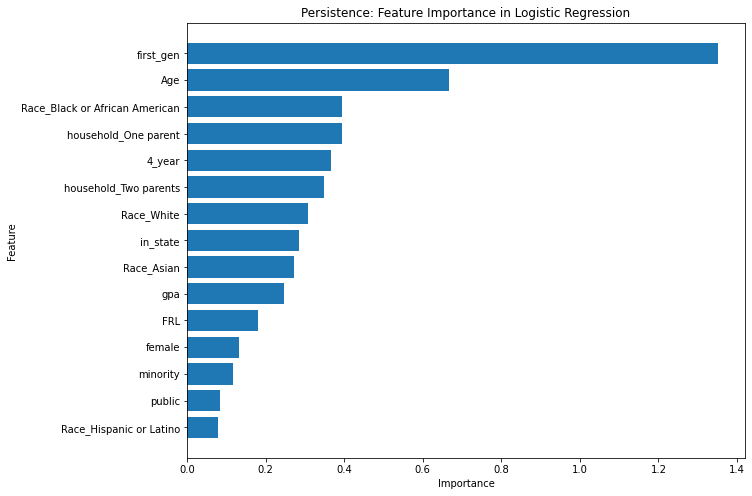

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Absolute Value'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Persistence: Feature Importance in Logistic Regression')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()


### svm

In [68]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.calibration import CalibratedClassifierCV

# Initialize the SVM model with linear kernel for similarity to L1
svm_model = SVC(kernel='linear', probability=True, random_state=66)

# Calibrated Classifier to enable probability prediction
calibrated_svm = CalibratedClassifierCV(svm_model)

# Train the model
calibrated_svm.fit(X_train, y_train)

# Predictions and probabilities
y_test_pred_svm = calibrated_svm.predict(X_test)
y_prob_svm = calibrated_svm.predict_proba(X_test)[:, 1]

# Evaluation Metrics
print("SVM Regularization:")
print(f"F1 Score: {f1_score(y_test, y_test_pred_svm):.4f}")
print(f"Precision Score: {precision_score(y_test, y_test_pred_svm):.4f}")
print(f"Recall Score: {recall_score(y_test, y_test_pred_svm):.4f}")
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob_svm):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_test_pred_svm)}")
print(classification_report(y_test, y_test_pred_svm))


SVM Regularization:
F1 Score: 0.6875
Precision Score: 0.8345
Recall Score: 0.5845
AUC-ROC Score: 0.8381
Confusion Matrix:
[[579  24]
 [ 86 121]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       603
           1       0.83      0.58      0.69       207

    accuracy                           0.86       810
   macro avg       0.85      0.77      0.80       810
weighted avg       0.86      0.86      0.86       810



In [84]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np

# Parameter distribution for RandomizedSearchCV
param_dist_svm = {
    'C': np.logspace(-4, 4, 20),  # Regularization strength (inverse)
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']  # Kernels to consider
}

# SVM model
svm_model = SVC(probability=True, random_state=66)  # Enable probability for ROC AUC

# Randomized Search with cross-validation
random_search_svm = RandomizedSearchCV(
    svm_model, 
    param_distributions=param_dist_svm, 
    n_iter=50, 
    scoring='roc_auc', 
    cv=5, 
    verbose=1, 
    random_state=66, 
    n_jobs=-1
)

# Fitting RandomizedSearchCV
random_search_svm.fit(X_train, y_train)

# Best model and predictions
best_svm = random_search_svm.best_estimator_
y_test_pred_svm = best_svm.predict(X_test)
y_prob_svm = best_svm.predict_proba(X_test)[:, 1]

# Evaluation Metrics
print("SVM Regularization with Hyperparameter Tuning:")
print(f"Best Parameters: {random_search_svm.best_params_}")
print(f"F1 Score: {f1_score(y_test, y_test_pred_svm):.4f}")
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob_svm):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_test_pred_svm)}")
print(classification_report(y_test, y_test_pred_svm))


Fitting 5 folds for each of 50 candidates, totalling 250 fits


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

SVM Regularization with Hyperparameter Tuning:
Best Parameters: {'kernel': 'rbf', 'C': 545.5594781168514}
F1 Score: 0.7131
AUC-ROC Score: 0.8403
Confusion Matrix:
[[579  24]
 [ 79 128]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       603
           1       0.84      0.62      0.71       207

    accuracy                           0.87       810
   macro avg       0.86      0.79      0.82       810
weighted avg       0.87      0.87      0.87       810



## XGBoost

In [74]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

# Splitting the dataset into training and testing sets
X = df_scaled.drop(columns=df_scaled[['dropout', 'college_name']])
y = df_scaled['dropout']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66, stratify=y)

# Initialize the XGBoost model with default parameters
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fit the model
xgb_model.fit(X_train, y_train)

# Predictions on the test set
y_test_pred = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Calculate the evaluation metrics
test_f1_xgb = f1_score(y_test, y_test_pred)
test_precision_xgb = precision_score(y_test, y_test_pred)
test_recall_xgb = recall_score(y_test, y_test_pred)
test_confusion_matrix_xgb = confusion_matrix(y_test, y_test_pred)
test_auc_roc_xgb = roc_auc_score(y_test, y_prob_xgb)

# Printing the results
print(f"Test Set F1 Score: {test_f1_xgb:.4f}")
print(f"Test Set Precision Score: {test_precision_xgb:.4f}")
print(f"Test Set Recall Score: {test_recall_xgb:.4f}")
print(f"Test Set Confusion Matrix:\n{test_confusion_matrix_xgb}")
print(f"Test Set AUC-ROC Score: {test_auc_roc_xgb:.4f}")

# Printing the classification report
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


Test Set F1 Score: 0.6580
Test Set Precision Score: 0.7159
Test Set Recall Score: 0.6087
Test Set Confusion Matrix:
[[553  50]
 [ 81 126]]
Test Set AUC-ROC Score: 0.8382

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89       603
           1       0.72      0.61      0.66       207

    accuracy                           0.84       810
   macro avg       0.79      0.76      0.78       810
weighted avg       0.83      0.84      0.83       810



In [75]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1, 2, 5, 10],
    'reg_lambda': [0, 0.1, 0.5, 1, 2, 5, 10]
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Initialize RandomizedSearchCV with AUC-ROC as the scoring metric
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=100, 
                                   scoring='roc_auc', cv=5, random_state=66, n_jobs=-1, verbose=1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model
best_xgb_model = random_search.best_estimator_

# Predictions on the test set
y_test_pred = best_xgb_model.predict(X_test)
y_prob_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# Calculate the evaluation metrics
test_f1_xgb = f1_score(y_test, y_test_pred)
test_precision_xgb = precision_score(y_test, y_test_pred)
test_recall_xgb = recall_score(y_test, y_test_pred)
test_confusion_matrix_xgb = confusion_matrix(y_test, y_test_pred)
test_auc_roc_xgb = roc_auc_score(y_test, y_prob_xgb)

# Printing the results
print(f"Best Parameters: {random_search.best_params_}")
print(f"Test Set F1 Score: {test_f1_xgb:.4f}")
print(f"Test Set Precision Score: {test_precision_xgb:.4f}")
print(f"Test Set Recall Score: {test_recall_xgb:.4f}")
print(f"Test Set Confusion Matrix:\n{test_confusion_matrix_xgb}")
print(f"Test Set AUC-ROC Score: {test_auc_roc_xgb:.4f}")
# Printing the classification report
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.4, 'colsample_bytree': 0.6}
Test Set F1 Score: 0.7022
Test Set Precision Score: 0.8389
Test Set Recall Score: 0.6039
Test Set Confusion Matrix:
[[579  24]
 [ 82 125]]
Test Set AUC-ROC Score: 0.8572

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       603
           1       0.84      0.60      0.70       207

    accuracy                           0.87       810
   macro avg       0.86      0.78      0.81       810
weighted avg       0.87      0.87      0.86       810



### GradientBoosting 

In [76]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

# Initialize the Gradient Boosting model with default parameters
gb_model = GradientBoostingClassifier()

# Fit the model
gb_model.fit(X_train, y_train)

# Predictions on the test set
y_test_pred = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

# Calculate the evaluation metrics
test_f1_gb = f1_score(y_test, y_test_pred)
test_precision_gb = precision_score(y_test, y_test_pred)
test_recall_gb = recall_score(y_test, y_test_pred)
test_confusion_matrix_gb = confusion_matrix(y_test, y_test_pred)
test_auc_roc_gb = roc_auc_score(y_test, y_prob_gb)

# Printing the results
print(f"Test Set F1 Score: {test_f1_gb:.4f}")
print(f"Test Set Precision Score: {test_precision_gb:.4f}")
print(f"Test Set Recall Score: {test_recall_gb:.4f}")
print(f"Test Set Confusion Matrix:\n{test_confusion_matrix_gb}")
print(f"Test Set AUC-ROC Score: {test_auc_roc_gb:.4f}")

# Printing the classification report
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


Test Set F1 Score: 0.7100
Test Set Precision Score: 0.8086
Test Set Recall Score: 0.6329
Test Set Confusion Matrix:
[[572  31]
 [ 76 131]]
Test Set AUC-ROC Score: 0.8613

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91       603
           1       0.81      0.63      0.71       207

    accuracy                           0.87       810
   macro avg       0.85      0.79      0.81       810
weighted avg       0.86      0.87      0.86       810



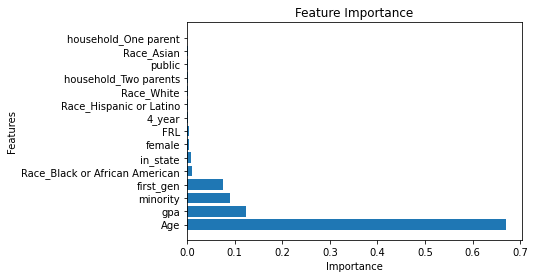

In [82]:
import matplotlib.pyplot as plt
import numpy as np

gb_model.fit(X_train, y_train)

feature_importances = gb_model.feature_importances_
features = X_train.columns

# Sorting the feature importances
sorted_indices = np.argsort(feature_importances)[::-1]

plt.barh(features[sorted_indices], feature_importances[sorted_indices])
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


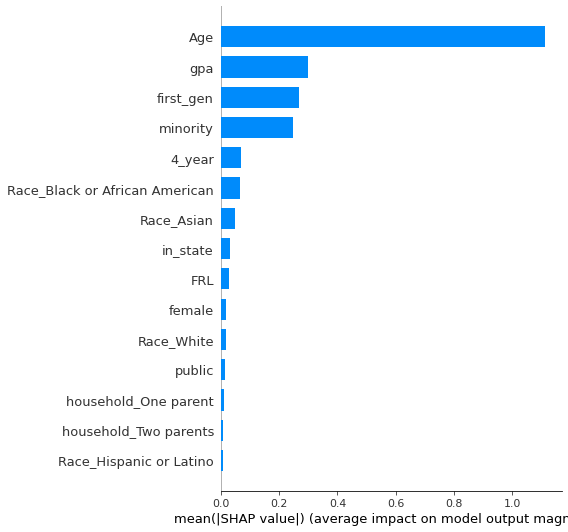

In [81]:
import numpy as np
import shap
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

# Fit the model
gb_model.fit(X_train, y_train)

# After confirming the model is trained, initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(gb_model)
shap_values = explainer.shap_values(X_train)

# Plotting SHAP values
shap.summary_plot(shap_values, X_train, plot_type="bar")


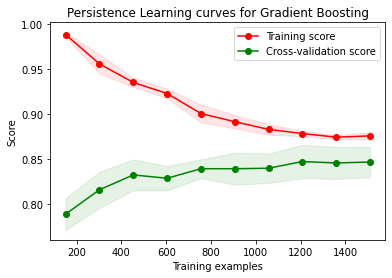

In [88]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=gb_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy'
)

# Mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, color='g', alpha=0.1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Persistence Learning curves for Gradient Boosting')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()


/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/ana

/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tongtianyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


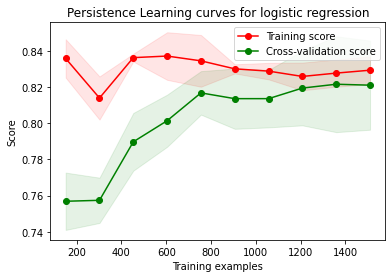

In [87]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_logistic_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy'
)

# Mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, color='g', alpha=0.1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Persistence Learning curves for logistic regression')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()


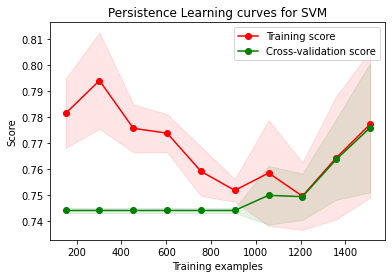

In [89]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=svm_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy'
)

# Mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, color='g', alpha=0.1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Persistence Learning curves for SVM')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()


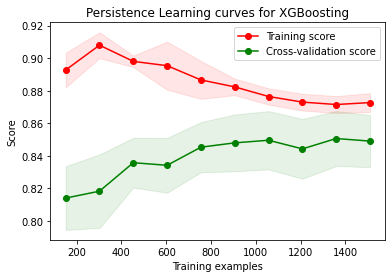

In [85]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_xgb_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy'
)

# Mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, color='g', alpha=0.1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title('Persistence Learning curves for XGBoosting')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()


The SVM learning curve (with training scores starting high and sharply decreasing, and validation scores rising then leveling off) suggests a better model. This curve shows that the model starts with potential overfitting but adjusts well as more data is introduced, resulting in a stable generalization indicated by both scores plateauing closely. The reduced gap between training and validation scores also suggests less overfitting compared to the logistic regression curve, where the gap remains slightly wider throughout the training. This makes the model  a better choice in terms of both fit and generalization.

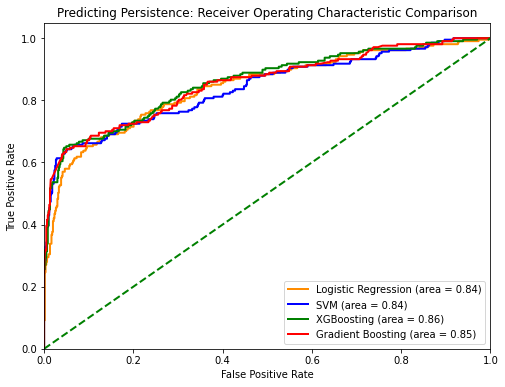

In [97]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assume y_prob_model1, y_prob_model2, y_prob_model3, y_prob_model4 are the probability predictions of the models
# Compute ROC curve and ROC area for each of the models
fpr1, tpr1, _ = roc_curve(y_test, y_prob_lr)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_prob_svm)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_test, y_prob_xgb)
roc_auc3 = auc(fpr3, tpr3)

fpr4, tpr4, _ = roc_curve(y_test, y_prob_gb)
roc_auc4 = auc(fpr4, tpr4)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='Logistic Regression (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='blue', lw=2, label='SVM (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='green', lw=2, label='XGBoosting (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='red', lw=2, label='Gradient Boosting (area = %0.2f)' % roc_auc4)
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting Persistence: Receiver Operating Characteristic Comparison')
plt.legend(loc="lower right")
plt.show()
